In [ ]:
!pip3 install tf-nightly


In [ ]:
!pip install numpy --upgrade

[INFO] loading Model...
[INFO] performing selective search with 'fast' method...
[INFO] 2063 regions found by selective search
[INFO] proposal shape: (183, 224, 224, 3)
[INFO] classifying proposals...
[[('donuts', 0.9744835)], [('cup_cakes', 0.9999628)], [('donuts', 1.0)], [('cup_cakes', 0.99998724)], [('chocolate_cake', 0.9956435)], [('cup_cakes', 0.91736454)], [('cup_cakes', 0.9999995)], [('cup_cakes', 0.9418717)], [('cup_cakes', 1.0)], [('cup_cakes', 0.76740134)], [('donuts', 1.0)], [('donuts', 0.9999697)], [('cup_cakes', 1.0)], [('cup_cakes', 1.0)], [('ice_cream', 0.9999602)], [('cup_cakes', 1.0)], [('chocolate_cake', 0.8925716)], [('cup_cakes', 1.0)], [('donuts', 1.0)], [('cup_cakes', 0.8666068)], [('cup_cakes', 0.9999938)], [('chocolate_cake', 0.98811406)], [('cup_cakes', 1.0)], [('chocolate_mousse', 0.98028755)], [('cup_cakes', 0.99998164)], [('cup_cakes', 1.0)], [('cup_cakes', 0.9912684)], [('donuts', 0.65520674)], [('cup_cakes', 1.0)], [('donuts', 0.99996686)], [('cup_cakes', 

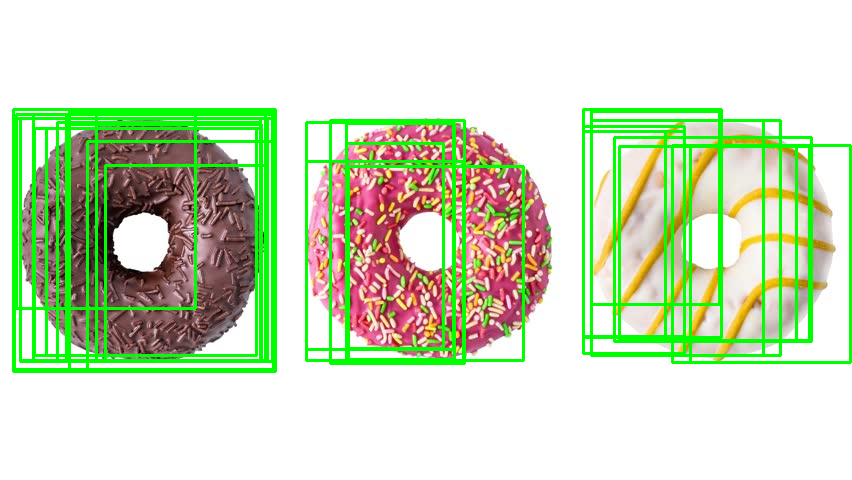

In [9]:
# import the necessary packages
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array
from imutils.object_detection import non_max_suppression
import numpy as np
import argparse
import cv2
from google.colab.patches import cv2_imshow
import json
import tensorflow.keras.backend as K

global CLASS_INDEX
fpath= "/content/classes.json"
def predictions(fpath, preds,top=1):
	with open(fpath) as f:
		CLASS_INDEX = json.load(f)
	results = []
	for pred in preds:
		top_indices = pred.argsort()[-top:][::-1]
		result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
		result.sort(key=lambda x: x[1], reverse=True)
		results.append(result)
	print(results)
	return results


def selective_search(image, method="fast"):
	# initialize OpenCV's selective search implementation and set the
	# input image
	ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
	ss.setBaseImage(image)
	# check to see if we are using the *fast* but *less accurate* version
	# of selective search
	if method == "fast":
		ss.switchToSelectiveSearchFast()
	# otherwise we are using the *slower* but *more accurate* version
	else:
		ss.switchToSelectiveSearchQuality()
	# run selective search on the input image
	rects = ss.process()
	# return the region proposal bounding boxes
	return rects


# load ResNet from disk (with weights pre-trained on ImageNet)
print("[INFO] loading Model...")

K.clear_session()
# model_best = load_model('bestmodel_15class_efficienetb0.hdf5',compile = False)
model = load_model('/content/bestmodel_15classinceptionbest.hdf5',compile=False)
# load the input image from disk and grab its dimensions
image = cv2.imread('/content/donuts.jpeg')
(H, W) = image.shape[:2]

# run selective search on the input image
print("[INFO] performing selective search with '{}' method...".format(
	"fast"))
rects = selective_search(image, method="fast")
print("[INFO] {} regions found by selective search".format(len(rects)))
# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes
proposals = []
boxes = []
labelFilters = ['donuts']

# loop over the region proposal bounding box coordinates generated by
# running selective search
for (x, y, w, h) in rects:
	# if the width or height of the region is less than 10% of the
	# image width or height, ignore it (i.e., filter out small
	# objects that are likely false-positives)
	if w / float(W) < .1 or h / float(H) < .1:
		continue
	# extract the region from the input image, convert it from BGR to
	# RGB channel ordering, and then resize it to 224x224 (the input
	# dimensions required by our pre-trained CNN)
	roi = image[y:y + h, x:x + w]
	roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
	roi = cv2.resize(roi, (224, 224))
	# further preprocess by the ROI
	roi = img_to_array(roi)
	roi = preprocess_input(roi)
	# update our proposals and bounding boxes lists
	proposals.append(roi)
	boxes.append((x, y, w, h))

    # convert the proposals list into NumPy array and show its dimensions
proposals = np.array(proposals)
print("[INFO] proposal shape: {}".format(proposals.shape))
# classify each of the proposal ROIs using ResNet and then decode the
# predictions
print("[INFO] classifying proposals...")
preds = model.predict(proposals)
preds = predictions(fpath,preds, top=1)
# print(preds)
# initialize a dictionary which maps class labels (keys) to any
# bounding box associated with that label (values)
labels = {}

# loop over the predictions
for (i, p) in enumerate(preds):
	# grab the prediction information for the current region proposal
	(label, prob) = p[0]
	# only if the label filters are not empty *and* the label does not
	# exist in the list, then ignore it
	if labelFilters is not None and label not in labelFilters:
		continue
	# filter out weak detections by ensuring the predicted probability
	# is greater than the minimum probability
	if prob >= 0.7:
		# grab the bounding box associated with the prediction and
		# convert the coordinates
		(x, y, w, h) = boxes[i]
		box = (x, y, x + w, y + h)
		# grab the list of predictions for the label and add the
		# bounding box + probability to the list
		L = labels.get(label, [])
		L.append((box, prob))
		labels[label] = L
		print(labels)

# loop over the labels for each of detected objects in the image
for label in labels.keys():
	# clone the original image so that we can draw on it
	print("[INFO] showing results for '{}'".format(label))
	clone = image.copy()
	# loop over all bounding boxes for the current label
	for (box, prob) in labels[label]:
		# draw the bounding box on the image
		(startX, startY, endX, endY) = box
		cv2.rectangle(clone, (startX, startY), (endX, endY),
			(0, 255, 0), 2)
	# show the results *before* applying non-maxima suppression, then
	# clone the image again so we can display the results *after*
	# applying non-maxima suppression
	cv2_imshow(clone)
	clone = image.copy()




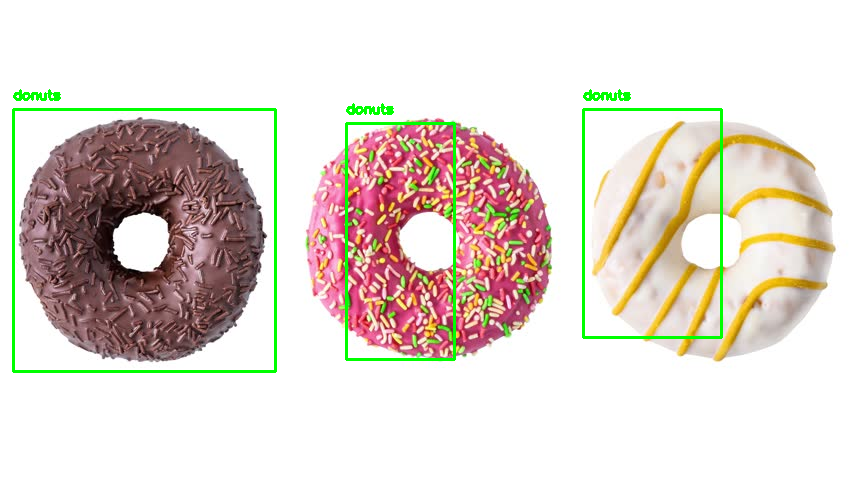

In [10]:
	# extract the bounding boxes and associated prediction
	# probabilities, then apply non-maxima suppression
import tensorflow as tf
	
boxes = np.array([p[0] for p in labels[label]])
proba = np.array([p[1] for p in labels[label]])
selected_indices = tf.image.non_max_suppression(boxes, proba,3,iou_threshold=0.4)
selected_boxes = tf.gather(boxes, selected_indices)

# loop over all bounding boxes that were kept after applying
# non-maxima suppression
for (startX, startY, endX, endY) in selected_boxes:
		cv2.rectangle(clone, (startX, startY), (endX, endY),(0, 255, 0), 2)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.putText(clone, label, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)
	# show the output after apply non-maxima suppression
cv2_imshow(clone)